In [ ]:
!pip install apyori
import pandas as pd
import numpy as np
from apyori import apriori
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv("/content/retail_dataset - retail_dataset.csv")
print("Shape of data:", df.shape)

# Preprocessing data into transactions
records = []
for i in range(0, 315):
    records.append([str(df.values[i, j]) for j in range(0, 7)])

# Apply Apriori algorithm
association_rule = apriori(records, min_support=0.20, min_confidence=0.30, min_lift=1.2, min_length=2)
result = list(association_rule)
print("Result length:", len(result))

# Filtering for two-item sets
two_item_results = [r for r in result if len(r.items) == 2]

# Create a list of dictionaries to hold the results
results_list = []
for item in two_item_results:
    pair = item.items
    items = [x for x in pair]
    support = item.support
    confidence = item.ordered_statistics[0].confidence
    lift = item.ordered_statistics[0].lift
    results_list.append({
        'Items': items,
        'Support': support,
        'Confidence': confidence,
        'Lift': lift
    })

# Create DataFrame from the list of dictionaries
results_df = pd.DataFrame(results_list)

# Print the DataFrame
print(results_df)


  Preparing metadata (setup.py) ... done
  Created wheel for apyori: filename=apyori-1.1.2-py3-none-any.whl size=5953 sha256=f35935f55be3caf2a8d5ee8a27563c4e44bb7661fc35db021130e5f8ce6e8122
  Stored in directory: /root/.cache/pip/wheels/c4/1a/79/20f55c470a50bb3702a8cb7c94d8ada15573538c7f4baebe2d
Successfully built apyori
Shape of data: (315, 7)
Result length: 15
            Items   Support  Confidence      Lift
0  [Bagel, Bread]  0.279365    0.656716  1.301042
1  [Cheese, Eggs]  0.298413    0.594937  1.358008
2  [Cheese, Meat]  0.323810    0.645570  1.355696
3  [Cheese, Milk]  0.304762    0.607595  1.211344
4  [Cheese, Wine]  0.269841    0.537975  1.227986
5  [Diaper, Wine]  0.234921    0.578125  1.319633
6    [Meat, Eggs]  0.266667    0.608696  1.278261
7    [Wine, Eggs]  0.241270    0.550725  1.257089
8    [Wine, Meat]  0.250794    0.526667  1.202174
9  [Pencil, Wine]  0.200000    0.552632  1.261442


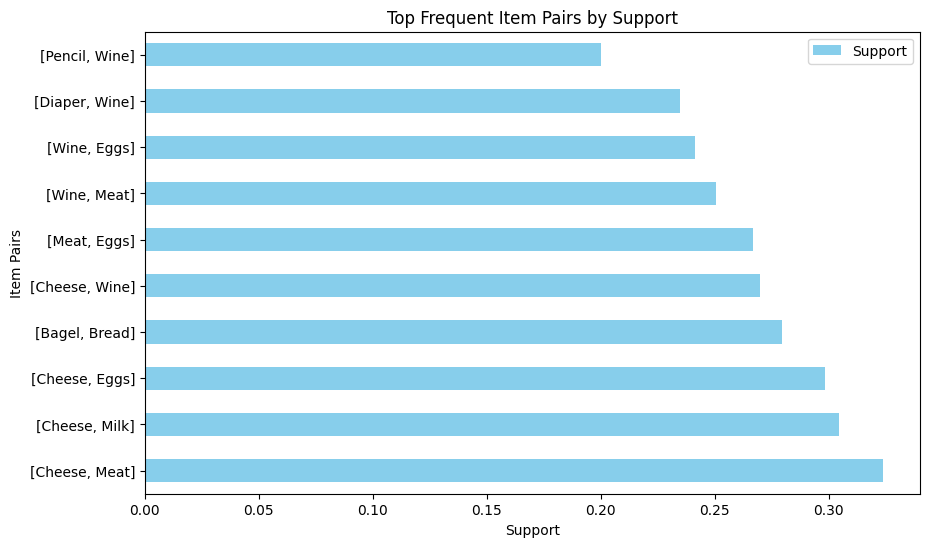

In [ ]:
# Plot top frequent items by support
results_df.sort_values(by='Support', ascending=False).head(10).plot(
    x='Items', y='Support', kind='barh', figsize=(10, 6), color='skyblue')
plt.title("Top Frequent Item Pairs by Support")
plt.xlabel("Support")
plt.ylabel("Item Pairs")
plt.show()


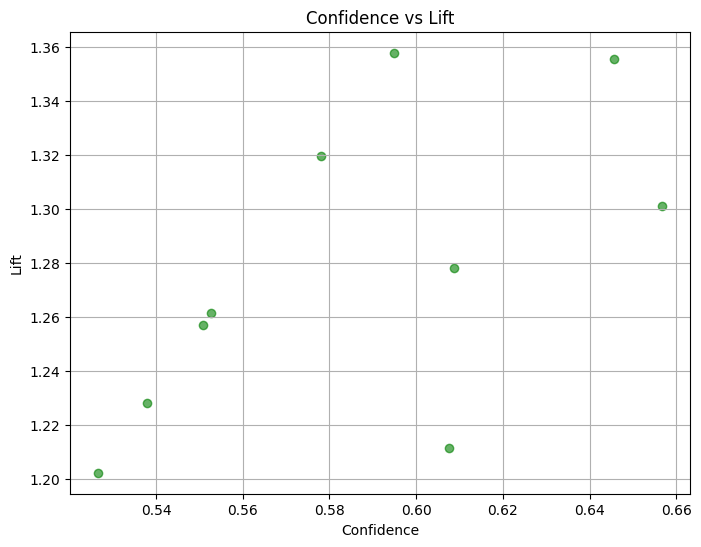

In [ ]:
# Scatter plot of confidence vs lift
plt.figure(figsize=(8,6))
plt.scatter(results_df['Confidence'], results_df['Lift'], alpha=0.6, color='green')
plt.title("Confidence vs Lift")
plt.xlabel("Confidence")
plt.ylabel("Lift")
plt.grid(True)
plt.show()


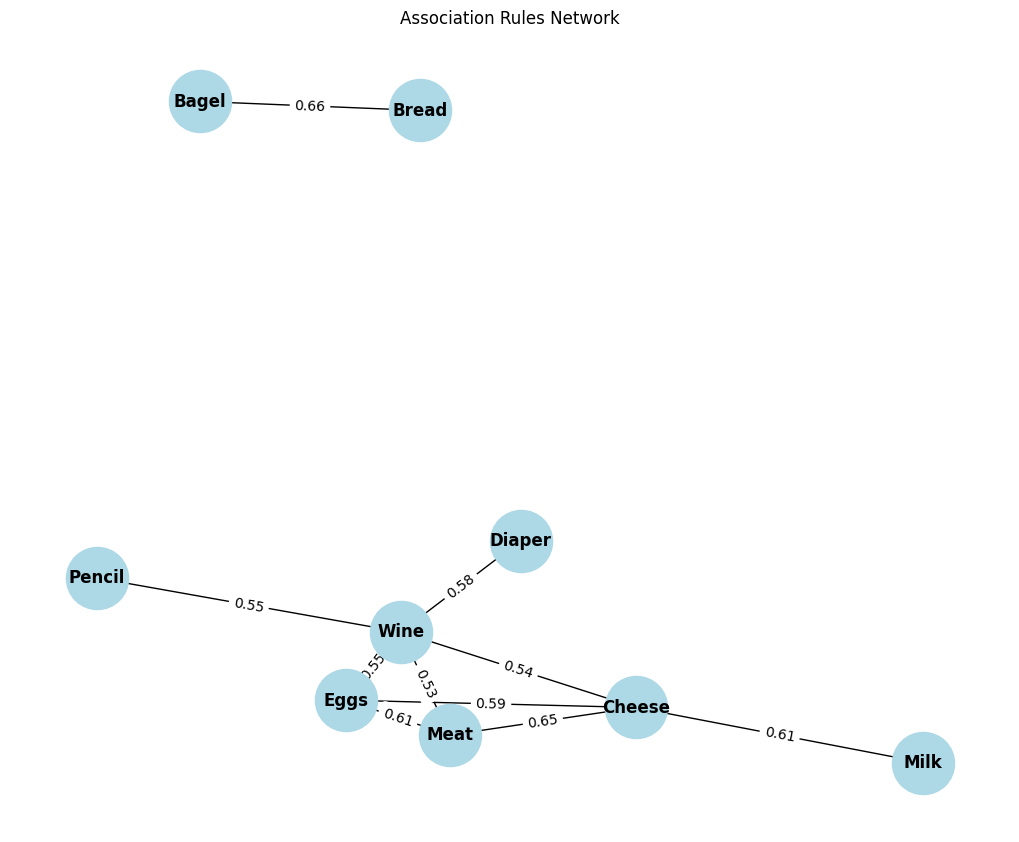

In [ ]:
import networkx as nx

# Create a graph
G = nx.Graph()

# Add edges to the graph
for index, row in results_df.iterrows():
    G.add_edge(row['Items'][0], row['Items'][1], weight=row['Confidence'])

# Draw the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='lightblue', font_size=12, font_weight='bold')
nx.draw_networkx_edge_labels(G, pos, edge_labels={(row['Items'][0], row['Items'][1]): f"{row['Confidence']:.2f}" for index, row in results_df.iterrows()})
plt.title("Association Rules Network")
plt.show()


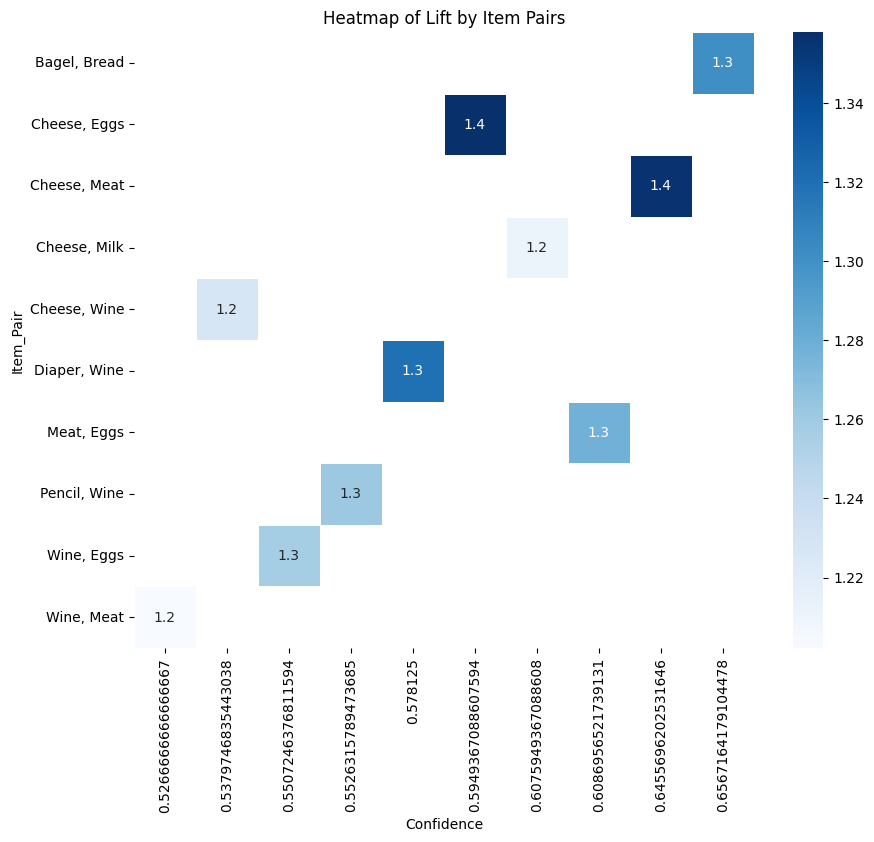

In [ ]:
import seaborn as sns

# Convert 'Items' lists to strings for better pivoting
results_df['Item_Pair'] = results_df['Items'].apply(lambda x: ', '.join(x))

# Create a pivot table for the heatmap
heatmap_data = results_df.pivot(index='Item_Pair', columns='Confidence', values='Lift')

# Draw heatmap
plt.figure(figsize=(10,8))
sns.heatmap(heatmap_data, annot=True, cmap='Blues', linewidths=0.5)
plt.title("Heatmap of Lift by Item Pairs")
plt.show()



In [ ]:
!pip install dash
import dash
from dash import dcc, html
from dash.dependencies import Input, Output
import plotly.express as px

# Initialize the Dash app
app = dash.Dash(__name__)

# Create a dropdown for thresholds and graphs
app.layout = html.Div([
    html.H1("Frequent Itemsets Dashboard"),

    # Filters for Support, Confidence, and Lift
    html.Label('Minimum Support:'),
    dcc.Slider(id='support-slider', min=0.0, max=1.0, step=0.01, value=0.20),

    html.Label('Minimum Confidence:'),
    dcc.Slider(id='confidence-slider', min=0.0, max=1.0, step=0.01, value=0.30),

    html.Label('Minimum Lift:'),
    dcc.Slider(id='lift-slider', min=1.0, max=10.0, step=0.1, value=1.2),

    # Graph for displaying filtered itemsets
    dcc.Graph(id='bar-graph'),

    # Graph for scatter plot of confidence vs. lift
    dcc.Graph(id='scatter-graph')
])

# Callback function to update the bar graph based on slider values
@app.callback(
    Output('bar-graph', 'figure'),
    Output('scatter-graph', 'figure'),
    [Input('support-slider', 'value'),
     Input('confidence-slider', 'value'),
     Input('lift-slider', 'value')]
)
def update_graph(min_support, min_confidence, min_lift):
    # Filter data based on selected thresholds
    filtered_df = results_df[(results_df['Support'] >= min_support) &
                             (results_df['Confidence'] >= min_confidence) &
                             (results_df['Lift'] >= min_lift)]

    # Create a bar plot for top item pairs by support
    bar_fig = px.bar(filtered_df, x='Item_Pair', y='Support',
                     title=f"Frequent Item Pairs (Support ≥ {min_support})",
                     labels={'Item_Pair': 'Item Pairs', 'Support': 'Support'})

    # Create a scatter plot for confidence vs. lift
    scatter_fig = px.scatter(filtered_df, x='Confidence', y='Lift',
                             size='Support', hover_name='Item_Pair',
                             title="Confidence vs Lift",
                             labels={'Confidence': 'Confidence', 'Lift': 'Lift'})

    return bar_fig, scatter_fig

# Run the app
if __name__ == '__main__':
    app.run_server(debug=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 32.9 MB/s eta 0:00:00


<IPython.core.display.Javascript object>

In [ ]:
!pip install fpdf
from fpdf import FPDF

def generate_report(results_df, top_recommendations):
    pdf = FPDF()
    pdf.set_auto_page_break(auto=True, margin=15)
    pdf.add_page()

    # Title
    pdf.set_font("Arial", 'B', 16)
    pdf.cell(0, 10, 'Market Basket Analysis Report', ln=True, align='C')

    # Section for frequent itemsets
    pdf.set_font("Arial", 'B', 14)
    pdf.cell(0, 10, 'Frequent Itemsets:', ln=True)
    pdf.set_font("Arial", '', 12)

    for index, row in results_df.iterrows():
        pdf.cell(0, 10, f"Items: {', '.join(row['Items'])}, Support: {row['Support']:.3f}, Confidence: {row['Confidence']:.3f}, Lift: {row['Lift']:.2f}", ln=True)

    # Section for recommendations
    pdf.add_page()
    pdf.set_font("Arial", 'B', 14)
    pdf.cell(0, 10, 'Top Recommendations:', ln=True)
    pdf.set_font("Arial", '', 12)

    for index, row in top_recommendations.iterrows():
        pdf.cell(0, 10, f"Items in Cart: {', '.join(row['Items in Cart'])}, Recommended Items: {', '.join(row['Recommended Items'])}, Confidence: {row['Confidence']:.3f}, Lift: {row['Lift']:.2f}", ln=True)

    # Save the PDF to a file
    pdf.output('market_basket_analysis_report.pdf')
    print("Report generated successfully!")

# Example usage (assuming results_df and top_recommendations are defined)
generate_report(results_df, top_recommendations)


  Preparing metadata (setup.py) ... done
  Created wheel for fpdf: filename=fpdf-1.7.2-py2.py3-none-any.whl size=40704 sha256=bca8c032aa02a66372d2769203e75ced4955b14c946511d505ea8e5061f97e77
  Stored in directory: /root/.cache/pip/wheels/f9/95/ba/f418094659025eb9611f17cbcaf2334236bf39a0c3453ea455
Successfully built fpdf
Report generated successfully!
